In [1]:
# 必要なライブラリの読み込み
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# データセットのダウンロード
# 2回目以降は実行する必要はありません
from urllib import request

# trainデータのダウンロード
url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/train.pickle'
request.urlretrieve(url, 'train.pickle')

# testデータのダウンロード
url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/test.pickle'
request.urlretrieve(url, 'test.pickle')

# ラベルデータのダウンロード
url = 'https://s3-ap-northeast-1.amazonaws.com/ai-std/label.pickle'
request.urlretrieve(url, 'label.pickle')

('label.pickle', <http.client.HTTPMessage at 0x1104ca7f0>)

In [3]:
# pickleのサンプルプログラム
import pickle

# 適当なオブジェクトを用意
obj = '保存されるオブジェクト'

# Pythonオブジェクトをpickleファイルとして保存
with open('sample.pickle','wb') as f:
    pickle.dump(obj, f) # (Pythonオブジェクト, pickleファイル)

# pickleファイルをPythonオブジェクトとして読込
with open('sample.pickle','rb') as f:
    loaded_obj = pickle.load(f)  # (pickleファイル)

# 読み込んだオブジェクトを確認
print(loaded_obj)

保存されるオブジェクト


In [4]:
# pickle形式のファイルを読み込む関数
# (保存されたpickleファイル)
def unpickle(file):
    # 保存されたpickleファイルを読み込み
    # 'rb'は｢読み込み専用(r)｣かつ｢バイト列(b)｣を意味する
    with open(file, 'rb') as f:
        return pickle.load(f, encoding='bytes')

In [5]:
# データの読み込みを実行
train = unpickle('train.pickle')
test = unpickle('test.pickle')
label = unpickle('label.pickle')

In [6]:
X_train = train['data']
y_train = train['label']
X_test = test['data']
y_test = test['label']

In [7]:
N_train = len(X_train)
N_test = len(X_test)
print(N_train, N_test)

2500 500


In [8]:
X_train.shape

(2500, 3, 32, 32)

In [9]:
X_train

array([[[[241., 242., 237., ...,  27.,  16.,   9.],
         [238., 239., 231., ...,  36.,  44.,  67.],
         [237., 233., 223., ...,  93.,  53., 111.],
         ...,
         [189., 192., 192., ..., 200., 210., 208.],
         [191., 195., 196., ..., 216., 226., 222.],
         [199., 204., 205., ..., 244., 246., 245.]],

        [[241., 242., 238., ...,  28.,  16.,   9.],
         [238., 239., 232., ...,  39.,  47.,  72.],
         [237., 234., 226., ..., 103.,  62., 120.],
         ...,
         [193., 196., 196., ..., 205., 217., 215.],
         [195., 199., 199., ..., 219., 229., 227.],
         [202., 207., 208., ..., 244., 246., 246.]],

        [[248., 249., 245., ...,  32.,  20.,  12.],
         [246., 248., 243., ...,  35.,  43.,  67.],
         [245., 245., 240., ...,  89.,  48., 110.],
         ...,
         [204., 208., 207., ..., 209., 225., 222.],
         [207., 211., 212., ..., 216., 233., 231.],
         [214., 219., 220., ..., 243., 248., 246.]]],


       [[[255.

In [10]:
X_train /= 255
X_test /= 255

In [11]:
def show_test_sample_info(index):
    # (channel, height, width)を(height, width, channel)に変換
    img = X_test[index].transpose(1,2,0)
    
    # 画像を出力
    plt.imshow(img)
    plt.show()
    
    # 正解ラベルを出力
    print('class: ' + label[y_test[index]])
    print('label: ' + str(y_test[index]))

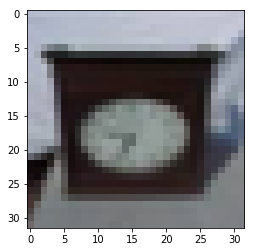

class: clock
label: 0


In [12]:
show_test_sample_info(99)

In [49]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers

In [50]:
class CNN(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=3, out_channels=64, ksize=4, stride=1, pad=2)
            self.conv2 = L.Convolution2D(in_channels=64, out_channels=128, ksize=4, stride=1, pad=2)
            self.conv3 = L.Convolution2D(in_channels=None, out_channels=128, ksize=4, stride=1, pad=2) # in_channelをNoneで省略
            self.fc4 = L.Linear(None, 512)
            self.fc5 = L.Linear(None, 5) # out_channelはクラス数と同じ5に設定
        
    def __call__(self, X):
        h = F.relu(F.max_pooling_2d(self.conv1(X), ksize=2)) # conv1の畳み込みのあとにMaxPoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv2(h), ksize=2)) # conv2の畳み込みのあとにMaxPpoolingを実行
        h = F.relu(F.max_pooling_2d(self.conv3(h), ksize=2)) # conv3の畳み込みのあとにMaxPoolingを実行
        h = F.relu(self.fc4(h))
        return self.fc5(h)

In [51]:
from chainer.datasets import tuple_dataset
from chainer.training import extensions
from chainer import optimizers, serializer, training, iterators

In [52]:
# 分類器インスタンスの生成
model = L.Classifier(CNN())

# optimizerの生成
optimizer = chainer.optimizers.SGD() # 今回はSGDを採用
optimizer.setup(model)               # モデルの構造を読み込ませる

# ミニバッチに含まれるサンプル数を指定
batchsize = 100

# epoch数を指定
n_epoch = 100

In [53]:
train = tuple_dataset.TupleDataset(X_train, y_train)
train_iter = iterators.SerialIterator(train, batch_size=batchsize, shuffle=True)
updater = training.StandardUpdater(train_iter, optimizer)
trainer = training.Trainer(updater, (n_epoch, 'epoch'), out='result')

In [54]:
test = tuple_dataset.TupleDataset(X_test,y_test)
test_iter = iterators.SerialIterator(test,batch_size=batchsize,shuffle=False,repeat=False)
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'validation/main/accuracy', 'validation/main/loss']))
trainer.extend(extensions.ProgressBar())
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [55]:
trainer.run()

epoch       main/accuracy  main/loss   validation/main/accuracy  validation/main/loss
1           0.2188         1.59521     0.21                      1.58258               
2           0.2376         1.57469     0.254                     1.56345               
3           0.2776         1.55693     0.29                      1.54377               
4           0.312          1.53863     0.318                     1.52239               
     total [##................................................]  4.00%
this epoch [..................................................]  0.00%
       100 iter, 4 epoch / 100 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
5           0.3276         1.51808     0.424                     1.49927               
6           0.3768         1.49389     0.37                      1.47413               
7           0.3824         1.47189     0.43                      1.44019               
8           0.4056         1.44442     0.49                  

55          0.786          0.625395    0.742                     0.72225               
56          0.7916         0.614061    0.72                      0.795093              
     total [############################......................] 56.00%
this epoch [..................................................]  0.00%
      1400 iter, 56 epoch / 100 epochs
   0.12936 iters/sec. Estimated time to finish: 2:21:43.171743.
57          0.7968         0.611703    0.706                     0.770756              
58          0.8032         0.581265    0.726                     0.757533              
59          0.8012         0.586988    0.712                     0.755663              
60          0.8048         0.571562    0.722                     0.799981              
     total [##############################....................] 60.00%
this epoch [..................................................]  0.00%
      1500 iter, 60 epoch / 100 epochs
   0.12382 iters/sec. Estimated time to finish

In [56]:
def predict(model, X):
    if len(X.shape) == 3:  # データ数が1の場合は、バッチサイズ分の次元を追加
        pred = model.predictor(X[None, ...]).data.argmax()
    else:  # データ数が2以上の場合はそのまま
        pred = model.predictor(X).data.argmax(axis=1)
    return pred

In [57]:
from sklearn import metrics
print('accuracy: %.3f' % metrics.accuracy_score(y_test, predict(model, X_test)))
print('recall: %.3f' % metrics.recall_score(y_test, predict(model, X_test), average='macro'))
print('precision: %.3f' % metrics.precision_score(y_test, predict(model, X_test), average='macro'))
print('f1_score: %.3f' % metrics.f1_score(y_test, predict(model, X_test), average='macro'))

accuracy: 0.782
recall: 0.782
precision: 0.792
f1_score: 0.783


In [58]:
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels, ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

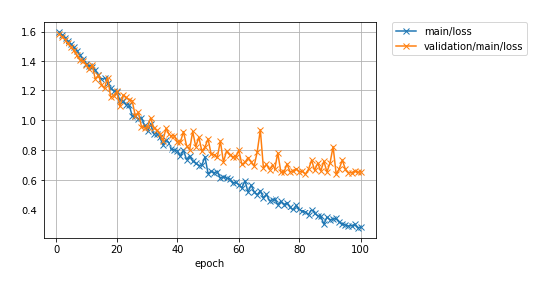

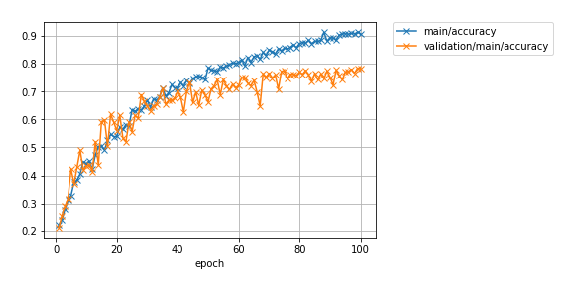

In [59]:
# 精度と誤差をグラフ描画
show_graph('result/loss.png')
show_graph('result/accuracy.png')

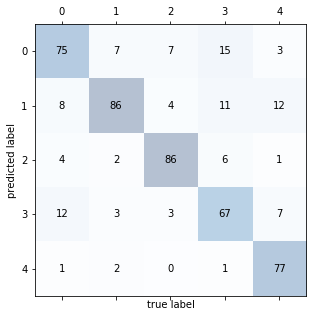

In [60]:
from sklearn.metrics import confusion_matrix as cm

# 混同行列きれいに出力する関数
def plot_cm(y_true, y_pred):
    confmat = cm(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xticks(np.arange(0, 5, 1))                               # x軸の目盛りを指定
    plt.yticks(np.arange(0, 5, 1))  
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()
    
# 混同行列を出力
result = predict(model, X_test)
plot_cm(result, y_test)